#### In this Jupyter Notebook, we have trained a CNN model on Intel Image Dataset that obtained from Kaggle.
#### The dataset consists of 150,150,3 RGB Images. There are 14034 Training, 3000 Test Images.
#### Later on, we created a validation set amongst the training images but randomly picking 20% of it (2806)
#### We conducted various experiments and the best performing model we achieved had a simplistic architecture with 2 CNN layers with batchnorm and max pooling layers following with 2 Linear Layers.

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import Adam, SGD

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [3]:
def load_data():
    
    datasets = ['seg_train', 'seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print(f"Loading {dataset}")

        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            for file in os.listdir(os.path.join(dataset, folder)):
                img_path = os.path.join(os.path.join(dataset, folder), file)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading seg_train
Loading seg_test


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [6]:
train_images = train_images / 255.0 #normalize

In [7]:
test_images = test_images / 255.0 #normalize

In [8]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


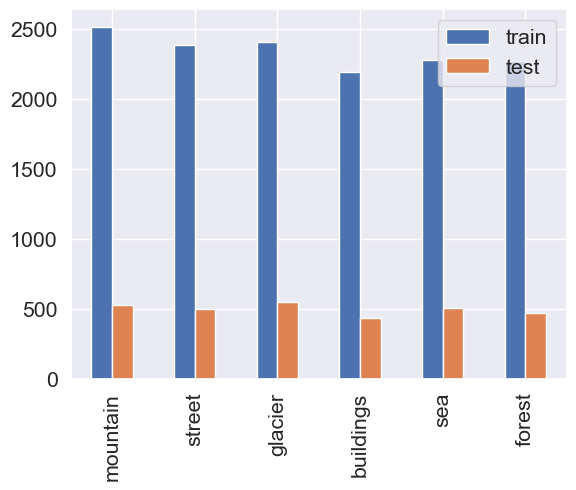

In [9]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

In [10]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    img = images[index] * 255.0
    plt.figure()
    plt.imshow(img.astype('uint8') )
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

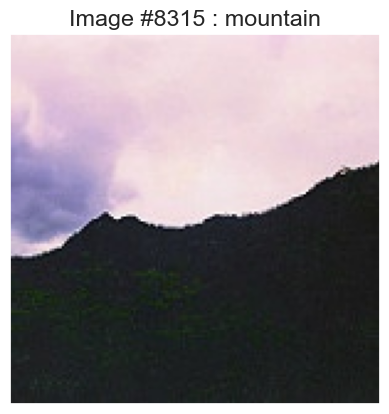

In [11]:
display_random_image(class_names, train_images, train_labels)

In [12]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        img = images[i] * 255.0
        
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img.astype('uint8'), cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

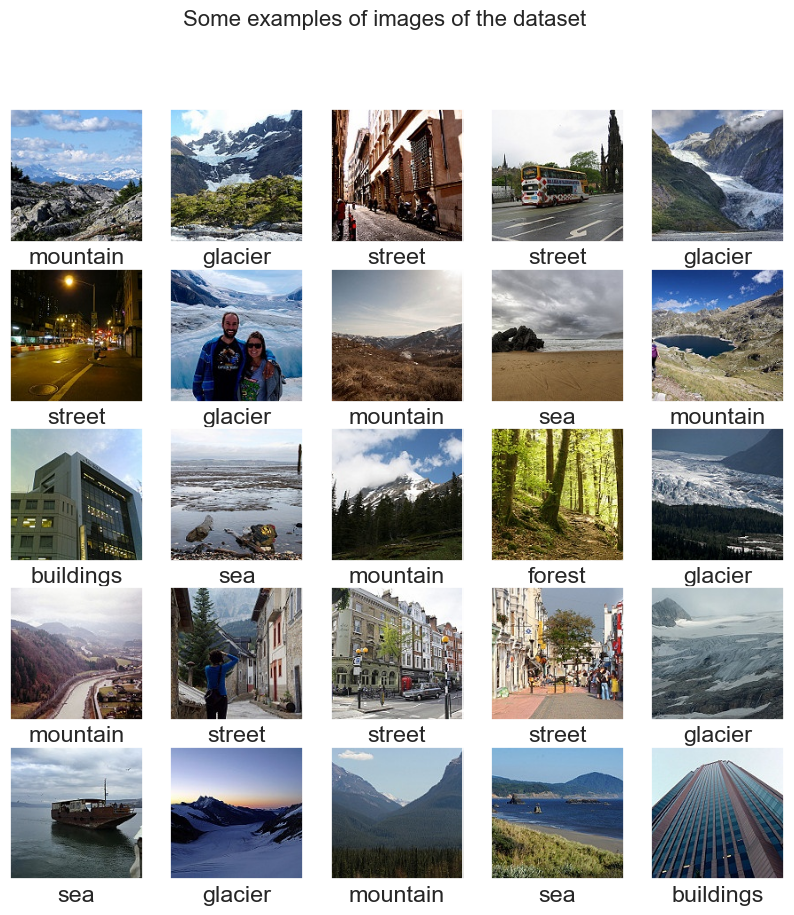

In [13]:
display_examples(class_names, train_images, train_labels)

In [14]:
# Assign device to gpu
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
device

device(type='cuda')

In [15]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images)
        self.labels = torch.tensor(labels)
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        image = image.permute(2, 0, 1)
        label = F.one_hot(self.labels[index].long(), num_classes=nb_classes)

        return image, label

In [16]:
trainset = CustomDataset(train_images, train_labels)

In [17]:
testset = CustomDataset(test_images, train_labels)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

In [18]:
val_len = len(trainset) // 5 #create validation set
trainset, valset = torch.utils.data.random_split(trainset, [len(trainset)-val_len, val_len])

In [19]:
valloader = DataLoader(valset, batch_size=128, shuffle=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)

In [20]:
len(valset)

2806

In [21]:
len(trainset)

11228

In [22]:
sum([item[1] for item in trainset])

tensor([1976, 1956, 1926, 1740, 1810, 1820])

In [23]:
sum([item[1] for item in valset])#check if the classes are still balanced after train-validation split

tensor([536, 426, 478, 451, 464, 451])

In [24]:
sum([item[1] for item in testset])

tensor([543, 490, 523, 503, 461, 480])

In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
            nn.Flatten(),
            nn.Linear(64*36*36, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, nb_classes)
        )

        # Initialize empty lists to store training and validation losses
        self.history = []
        self.batch_history = []
        self.val_history = []

    def forward(self, x):
        # Convert input data to the appropriate data type and device
        x = x.to(dtype=torch.float32)
        x = x.to(device)

        # Pass input through the model
        x = self.model(x)

        return x

In [37]:
def train(dl, model, optimizer, n_epochs=10, valdl=None):
    # Define the loss function
    L = nn.CrossEntropyLoss()
    
    # Loop over the number of epochs
    for epoch in range(n_epochs):
        # Set the model to train mode
        model.train()
        
        # Initialize empty lists to store the batch loss and validation batch loss
        batch_loss = []
        val_batch_loss = []
        for x, y in dl:
            # Move data to device (Data and the model has to be assigned to the same device)
            y = y.to(dtype=torch.float32)
            y = y.to(device)
            
            
            # Zero out the optimizer gradients at the beginning of each epoch
            optimizer.zero_grad()
            
            # Forward pass
            out = model(x)
            
            # Compute the loss
            loss = L(out, y)
            
            # Backward pass
            loss.backward()
            
            # Update the optimizer
            optimizer.step()
            
            # Append the batch loss to the list
            batch_loss.append(loss.item())
            
            # Append the batch loss to the model batch history
            model.batch_history.append(loss.item())
        
        # Append the mean batch loss of the epoch to the model history
        model.history.append(np.array(batch_loss).mean())
        
        # If a validation data loader is provided
        if valdl:
            # Disable gradient computation
            with torch.no_grad():
                for valx, valy in valdl:
                    # Move data to device
                    valy = valy.to(dtype=torch.float32)
                    valy = valy.to(device)
                    
                    # Forward pass
                    out = model(valx)
                    
                    # Compute the loss
                    loss = L(out, valy)
                    
                    # Append the validation batch loss to the list
                    val_batch_loss.append(loss.item())
                    
                # Append the mean validation batch loss to the model validation history
                model.val_history.append(np.array(val_batch_loss).mean())
                
                # Print the epoch number, training loss, and validation loss
                print(f'Epoch {len(model.history)}: Loss: {np.array(batch_loss).mean():.4f}, ValLoss: {np.array(val_batch_loss).mean():.4f}')
        # If no validation data loader is provided
        else:
            # Print the epoch number and training loss
            print(f'Epoch {len(model.history)}: Loss: {np.array(batch_loss).mean():.4f}')
            
            
def evaluate(dl, model):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize variables to track correct and incorrect predictions
    true, false = 0, 0
    
    # Loop over the data loader
    for xs, ys in dl:
        # Move data to device
        xs, ys = xs.to(device), ys.to(device)
        
        # Forward pass
        preds = model(xs)
        
        # Convert predictions to class labels
        preds = [pred.argmax() for pred in preds]
        
        # Loop over the predictions and true labels
        for pred, y in zip(preds, ys):
            
            # Increment the correct count if the prediction is correct
            if pred == y.argmax():
                true += 1
            # Increment the incorrect count if the prediction is incorrect
            else:
                false += 1
                
    # Compute the accuracy
    accuracy = true/(true+false)
    
    # Return the accuracy
    return accuracy 

In [27]:
# Create the model and move it to device
model = Net()
model = model.to(device)

In [28]:
# Initialize the Adam optimizer with it's default values and model parameters
optimizer = Adam(model.parameters())

In [29]:
# Train for 10 epochs
train(trainloader, model, optimizer, n_epochs=10, valdl=valloader)

Epoch 1: Loss: 3.0175, ValLoss: 1.1760
Epoch 2: Loss: 1.0535, ValLoss: 1.0049
Epoch 3: Loss: 0.9106, ValLoss: 0.9324
Epoch 4: Loss: 0.7675, ValLoss: 0.8362
Epoch 5: Loss: 0.6856, ValLoss: 0.8049
Epoch 6: Loss: 0.6102, ValLoss: 0.7775
Epoch 7: Loss: 0.5767, ValLoss: 0.7843
Epoch 8: Loss: 0.5161, ValLoss: 0.8080
Epoch 9: Loss: 0.4734, ValLoss: 0.7494
Epoch 10: Loss: 0.4156, ValLoss: 0.7645


In [30]:
print(evaluate(trainloader, model), evaluate(valloader, model), evaluate(testloader, model))

0.9072853580334878 0.8036350677120456 0.81233333333333333


In [31]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64*37*37, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, nb_classes)
        )

        # Initialize empty lists to store training and validation losses
        self.history = []
        self.batch_history = []
        self.val_history = []

    def forward(self, x):
        # Convert input data to the appropriate data type and device
        x = x.to(dtype=torch.float32)
        x = x.to(device)

        # Pass input through the model
        x = self.model(x)

        return x

In [32]:
# Create the model and move it to device
model = Net2()
model = model.to(device)

# Initialize the Adam optimizer with it's default values and model parameters
optimizer = Adam(model.parameters())

In [33]:
# Train for 200 epochs
train(trainloader, model, optimizer, n_epochs=10, valdl=valloader)

Epoch 1: Loss: 1.1825, ValLoss: 0.7571
Epoch 2: Loss: 0.5715, ValLoss: 0.6802
Epoch 3: Loss: 0.3765, ValLoss: 0.6599
Epoch 4: Loss: 0.2320, ValLoss: 0.6921
Epoch 5: Loss: 0.1403, ValLoss: 0.7061
Epoch 6: Loss: 0.0830, ValLoss: 0.8174
Epoch 7: Loss: 0.0493, ValLoss: 0.8698
Epoch 8: Loss: 0.0440, ValLoss: 0.9271
Epoch 9: Loss: 0.0280, ValLoss: 1.0086
Epoch 10: Loss: 0.0375, ValLoss: 0.9849


In [40]:
print(evaluate(trainloader, model), evaluate(valloader, model), evaluate(testloader, model))

0.9918952618453866 0.7979330007127584 0.756
